# Project Overview

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Business Case/Problem

## Data Description

## Data Load

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.

## Split Data into Training and Test set

In [35]:
target = df['price']
features = df.drop(['price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2,random_state=42)
x_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6243,9834201100,12/22/2014,4,2.00,1440,4855,2.0,0.0,0.0,4,7,1440,0.0,1972,0.0,98144,47.5717,-122.287,1300,4080
8986,7795810110,5/12/2015,3,1.75,1430,9857,1.0,0.0,2.0,4,7,1140,290.0,1980,0.0,98045,47.4964,-121.771,1310,9880
9419,1853081250,12/29/2014,4,2.75,3120,5000,2.0,0.0,0.0,3,9,3120,0.0,2010,0.0,98074,47.5940,-122.062,3200,5000
10155,2558630350,3/21/2015,4,2.50,2060,6958,1.0,0.0,0.0,3,7,1220,840.0,1974,NaN,98034,47.7251,-122.168,1760,7350
10436,3362401000,7/1/2014,3,2.00,2500,4080,1.5,0.0,0.0,5,7,1680,820.0,1922,0.0,98103,47.6813,-122.346,1550,3060


## Data Cleaning

Let's review columns to see which ones make the most sense to keep.

In [37]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
columns_to_keep = ['bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'sqft_basement',
                  'yr_built',
                  'zipcode'
                  ]

In [6]:
def filter_columns(df):
    columns_to_keep = ['bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode'
                  ]
    return df[columns_to_keep]

In [36]:
df_filtered = filter_columns(x_train)
df_filtered.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode
6243,4,2.00,1440,4855,2.0,4,7,1440,1972,98144
8986,3,1.75,1430,9857,1.0,4,7,1140,1980,98045
9419,4,2.75,3120,5000,2.0,3,9,3120,2010,98074
10155,4,2.50,2060,6958,1.0,3,7,1220,1974,98034
10436,3,2.00,2500,4080,1.5,5,7,1680,1922,98103


In [64]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 753 to 15795
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     15117 non-null  int64  
 1   bathrooms    15117 non-null  float64
 2   sqft_living  15117 non-null  int64  
 3   sqft_lot     15117 non-null  int64  
 4   floors       15117 non-null  float64
 5   condition    15117 non-null  int64  
 6   grade        15117 non-null  int64  
 7   sqft_above   15117 non-null  int64  
 8   yr_built     15117 non-null  int64  
 9   zipcode      15117 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


Missing data from 'waterfront' column will need to be addressed.

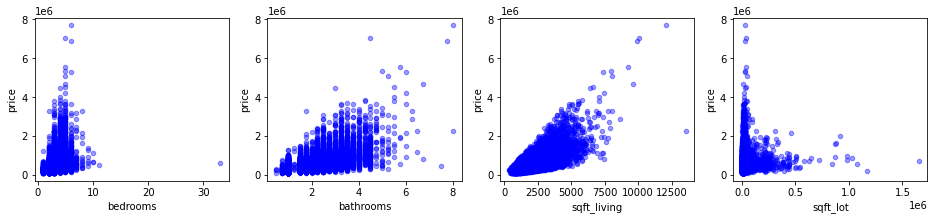

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 
                     'bathrooms',
                     'sqft_living',
                     'sqft_lot', 
                     ], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

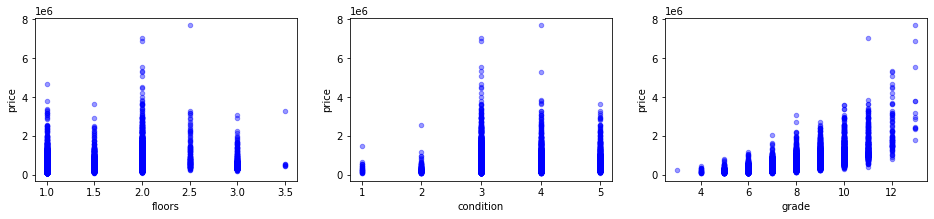

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['floors',
                     'condition',
                     'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

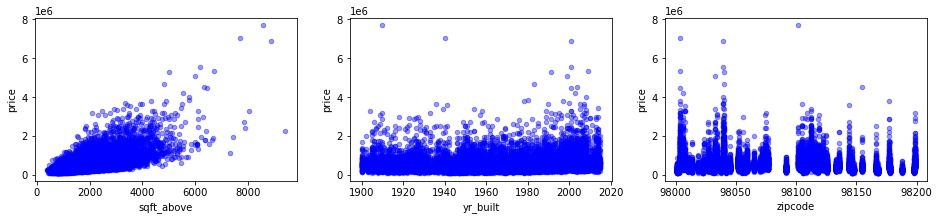

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_above',
                    'yr_built',
                    'zipcode'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

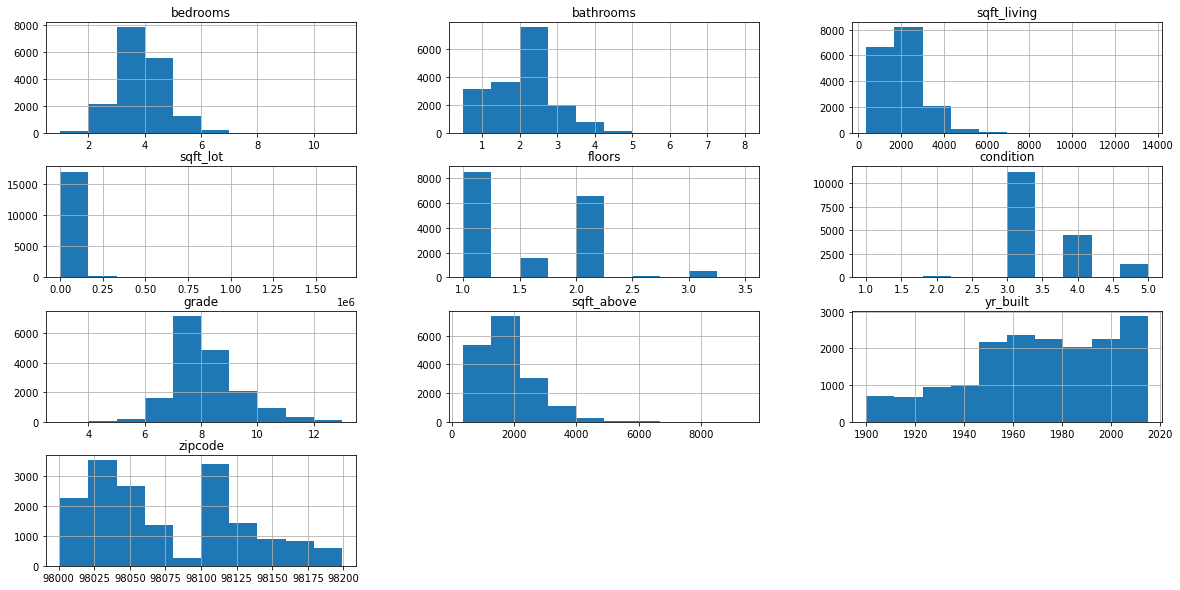

In [40]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_filtered.hist(ax = ax);

## Log Transformations

## Feature Scaling

## Check for Multicol

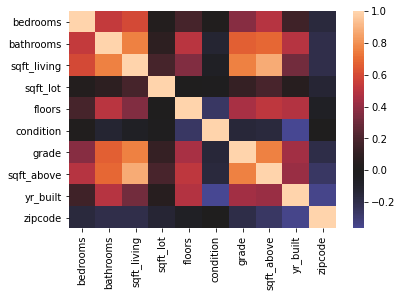

In [12]:
sns.heatmap(df_filtered.corr(), center=0);

## Create Dummy Variables

In [58]:
df_filtered['yr_built'] = df_filtered['yr_built'].astype('str')
df_filtered['zipcode'] = df_filtered['zipcode'].astype('str')
df_filtered['floors'] = df_filtered['floors'].astype('str')

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 6243 to 15795
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     17277 non-null  int64  
 1   bathrooms    17277 non-null  float64
 2   sqft_living  17277 non-null  int64  
 3   sqft_lot     17277 non-null  int64  
 4   floors       17277 non-null  object 
 5   condition    17277 non-null  int64  
 6   grade        17277 non-null  int64  
 7   sqft_above   17277 non-null  int64  
 8   yr_built     17277 non-null  object 
 9   zipcode      17277 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 2.1+ MB


In [19]:
df_filtered.zipcode.unique()

array(['98053', '98178', '98003', '98022', '98055', '98103', '98155',
       '98065', '98008', '98001', '98040', '98126', '98052', '98023',
       '98107', '98075', '98005', '98092', '98112', '98059', '98133',
       '98102', '98031', '98122', '98168', '98117', '98146', '98188',
       '98115', '98027', '98006', '98136', '98028', '98105', '98029',
       '98038', '98045', '98024', '98166', '98072', '98074', '98108',
       '98144', '98125', '98004', '98106', '98019', '98198', '98118',
       '98034', '98109', '98058', '98002', '98033', '98199', '98042',
       '98010', '98077', '98056', '98007', '98070', '98030', '98119',
       '98116', '98014', '98177', '98148', '98011', '98032', '98039'],
      dtype=object)

In [49]:
df_filtered.yr_built.unique()

array(['1955', '1951', '1933', '1965', '1987', '2001', '1995', '1963',
       '1960', '2003', '1942', '1927', '1977', '1900', '1979', '1994',
       '1916', '1921', '1969', '1947', '1968', '1985', '1941', '1915',
       '1909', '1948', '2005', '1929', '1981', '1930', '1904', '1996',
       '2000', '1984', '2014', '1922', '1959', '1966', '1953', '1950',
       '2008', '1991', '1954', '1973', '1925', '1989', '1972', '1986',
       '1956', '2002', '1992', '1964', '1952', '1961', '2006', '1988',
       '1962', '1939', '1946', '1967', '1975', '1980', '1910', '1983',
       '1978', '1905', '1971', '2010', '1945', '1924', '1990', '1914',
       '1926', '2004', '1923', '2007', '1976', '1949', '1999', '1901',
       '1993', '1920', '1997', '1943', '1957', '1940', '1918', '1928',
       '1974', '1911', '1936', '1937', '1982', '1908', '1931', '1998',
       '1913', '2013', '1907', '1958', '2012', '1912', '2011', '1917',
       '1932', '1944', '1902', '2009', '1903', '1970', '2015', '1934',
      

In [67]:
df_filtered.floors.unique()

array(['2.0', '1.0', '1.5', '3.0', '2.5', '3.5'], dtype=object)

In [71]:
df_filtered.bathrooms.unique()

array([2.  , 1.75, 2.75, 2.5 , 1.  , 1.5 , 2.25, 3.  , 3.5 , 3.25, 0.75,
       5.  , 6.25, 3.75, 4.25, 4.75, 4.5 , 7.75, 4.  , 6.5 , 1.25, 0.5 ,
       5.75, 6.  , 5.25, 8.  , 5.5 , 6.75])

In [72]:
df_filtered.bedrooms.unique()

array([ 4,  3,  2,  1,  5,  6,  7,  8, 11,  9, 10])

In [73]:
df_filtered.condition.unique()

array([4, 3, 5, 2, 1])

In [59]:
zip_dummies = pd.get_dummies(df_filtered['zipcode'], prefix='zip', drop_first=True)
yr_dummies = pd.get_dummies(df_filtered['yr_built'], prefix='yr', drop_first=True)
floor_dummies = pd.get_dummies(df_filtered['floors'], prefix='flr', drop_first=True)

In [60]:
df_dummies = df_filtered.drop(['zipcode','yr_built','floors'], axis=1)

In [61]:
df_dummies = pd.concat([df_filtered, zip_dummies, yr_dummies, floor_dummies], axis=1)
df_dummies

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,flr_1.5,flr_2.0,flr_2.5,flr_3.0,flr_3.5
6243,4,2.00,1440,4855,2.0,4,7,1440,1972,98144,...,0,0,0,0,0,0,1,0,0,0
8986,3,1.75,1430,9857,1.0,4,7,1140,1980,98045,...,0,0,0,0,0,0,0,0,0,0
9419,4,2.75,3120,5000,2.0,3,9,3120,2010,98074,...,0,0,0,0,0,0,1,0,0,0
10155,4,2.50,2060,6958,1.0,3,7,1220,1974,98034,...,0,0,0,0,0,0,0,0,0,0
10436,3,2.00,2500,4080,1.5,5,7,1680,1922,98103,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2.50,2230,5800,2.0,3,7,2230,2004,98065,...,0,0,0,0,0,0,1,0,0,0
21575,4,2.75,2770,3852,2.0,3,8,2770,2014,98178,...,0,0,0,1,0,0,1,0,0,0
5390,4,1.50,1530,9000,1.0,4,6,1530,1976,98014,...,0,0,0,0,0,0,0,0,0,0
860,1,0.75,380,15000,1.0,3,5,380,1963,98168,...,0,0,0,0,0,0,0,0,0,0


## Model A (Simple Model)

In [78]:
data_fin = pd.DataFrame([])
price = y_train
bedrooms = x_train['bedrooms']
bathrooms = x_train['bathrooms']
sqft_living = x_train['sqft_living']
grade = x_train['grade']

In [80]:
simple_model_ols = pd.concat([price, bedrooms, bathrooms, sqft_living, grade], axis=1)
simple_model_ols.head()

,price,bedrooms,bathrooms,sqft_living,grade
6243,332500.0,4,2.00,1440,7
8986,390000.0,3,1.75,1430,7
9419,800000.0,4,2.75,3120,9
10155,462000.0,4,2.50,2060,7
10436,695000.0,3,2.00,2500,7


In [81]:
outcome = 'price'
predictors = simple_model_ols.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [82]:
model = ols(formula=formula, data=simple_model_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     5184.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:18:33   Log-Likelihood:            -2.3917e+05
No. Observations:               17277   AIC:                         4.783e+05
Df Residuals:                   17272   BIC:                         4.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -4.87e+05    1.7e+04    -28.689      0.000    -5.2e+05   -4.54e+05
bedrooms    -4.335e+04   2685.131    -16.143      0.000   -4.86e+04   -3.81e+04
bathrooms   -2.448e+04   3936.106     -6.219      0.000   -3.22e+04   -1.68e+04
sqft_living   227.8517      4.065     56.054      0.000     219.884     235.819
grade        9.819e+04   2607.614     37.654      0.000    9.31e+04    1.03e+05
==============================================================================
Omnibus:                    12674.639   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           584848.422
Skew:                           3.045   Prob(JB):                         0.00
Kurtosis:                      30.845   Cond. No.                     2.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
y = simple_model_ols['price']
linreg = LinearRegression()
linreg.fit(predictors, y)

LinearRegression()

In [84]:
linreg.coef_

array([-43346.87097738, -24480.19836325,    227.8517448 ,  98187.07710573])

In [85]:
linreg.intercept_

-487046.2750142581

## Cross Validation

## Model B

In [74]:
data_fin = pd.DataFrame([])
price = y_train
bedrooms = x_train['bedrooms']
bathrooms = x_train['bathrooms']
sqft_living = x_train['sqft_living']            

In [75]:
model_b_ols = pd.concat([price, bedrooms, bathrooms, sqft_living, zip_dummies, yr_dummies], axis=1)
model_b_ols.head()

,price,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,...,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015
6243,332500.0,4,2.00,1440,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8986,390000.0,3,1.75,1430,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9419,800000.0,4,2.75,3120,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10155,462000.0,4,2.50,2060,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10436,695000.0,3,2.00,2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [76]:
outcome = 'price'
predictors = model_b_ols.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [77]:
model = ols(formula=formula, data=model_b_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     271.1
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        15:17:07   Log-Likelihood:            -2.3408e+05
No. Observations:               17277   AIC:                         4.685e+05
Df Residuals:                   17089   BIC:                         4.700e+05
Df Model:                         187                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.009e+04   2.58e+04     -2.328      0.020   -1.11e+05   -9489.464
bedrooms    -5.131e+04   2083.786    -24.623      0.000   -5.54e+04   -4.72e+04
bathrooms    2.977e+04   3404.783      8.745      0.000    2.31e+04    3.64e+04
sqft_living   270.8864      2.716     99.729      0.000     265.562     276.210
zip_98002    2.091e+04   1.89e+04      1.107      0.268   -1.61e+04     5.8e+04
zip_98003    1.797e+04   1.68e+04      1.069      0.285    -1.5e+04    5.09e+04
zip_98004    7.805e+05   1.65e+04     47.428      0.000    7.48e+05    8.13e+05
zip_98005    3.484e+05   1.96e+04     17.733      0.000     3.1e+05    3.87e+05
zip_98006    3.203e+05   1.48e+04     21.654      0.000    2.91e+05    3.49e+05
zip_98007     2.81e+05   2.09e+04     13.432      0.000     2.4e+05    3.22e+05
zip_98008    3.209e+05   1.68e+04     19.091      0.000    2.88e+05    3.54e+05
zip_98010    8.137e+04   2.33e+04      3.496      0.000    3.57e+04    1.27e+05
zip_98011    1.203e+05   1.88e+04      6.402      0.000    8.35e+04    1.57e+05
zip_98014    9.516e+04   2.13e+04      4.471      0.000    5.34e+04    1.37e+05
zip_98019    7.101e+04   1.89e+04      3.751      0.000    3.39e+04    1.08e+05
zip_98022    4.421e+04   1.77e+04      2.492      0.013    9437.400     7.9e+04
zip_98023   -5272.4630   1.45e+04     -0.364      0.716   -3.37e+04    2.31e+04
zip_98024    1.681e+05    2.5e+04      6.723      0.000    1.19e+05    2.17e+05
zip_98027    1.759e+05   1.51e+04     11.684      0.000    1.46e+05    2.05e+05
zip_98028     1.21e+05   1.67e+04      7.236      0.000    8.82e+04    1.54e+05
zip_98029      2.4e+05   1.63e+04     14.703      0.000    2.08e+05    2.72e+05
zip_98030    1.076e+04   1.74e+04      0.620      0.535   -2.33e+04    4.48e+04
zip_98031    2.269e+04   1.68e+04      1.353      0.176   -1.02e+04    5.56e+04
zip_98032    1.377e+04   2.18e+04      0.631      0.528    -2.9e+04    5.65e+04
zip_98033    3.906e+05   1.51e+04     25.793      0.000    3.61e+05     4.2e+05
zip_98034    2.264e+05   1.42e+04     15.907      0.000    1.99e+05    2.54e+05
zip_98038    2.674e+04   1.42e+04      1.882      0.060   -1110.728    5.46e+04
zip_98039    1.412e+06   3.06e+04     46.189      0.000    1.35e+06    1.47e+06
zip_98040    6.133e+05   1.69e+04     36.235      0.000     5.8e+05    6.47e+05
zip_98042    1.815e+04   1.43e+04      1.268      0.205   -9906.440    4.62e+04
zip_98045     1.13e+05   1.76e+04      6.412      0.000    7.85e+04    1.48e+05
zip_98052    2.499e+05   1.42e+04     17.623      0.000    2.22e+05    2.78e+05
zip_98053    2.032e+05   1.55e+04     13.087      0.000    1.73e+05    2.34e+05
zip_98055    4.448e+04   1.67e+04      2.658      0.008    1.17e+04    7.73e+04
zip_98056    1.123e+05   1.53e+04      7.364      0.000    8.24e+04    1.42e+05
zip_98058    4.699e+04   1.49e+04      3.14

In [86]:
updated_zip = zip_dummies.drop(['zip_98002','zip_98003','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042',
                 'zip_98092','zip_98188'], axis=1)
updated_zip

,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,...,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98198,zip_98199
6243,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5390,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Model C

## Model D

## Feature Engineering

## Model Training

## Model Evaluation

## Conclusions/Summary